# ROME: Realistic one-shot mesh-based head avatars




![extreme](../media/tease0.gif)

[ROME](https://samsunglabs.github.io/rome/) Project Page Don't forget to check orignal [DECA](https://github.com/YadiraF/DECA/) project.

[![Taras](https://img.shields.io/twitter/follow/t_khakhulin?style=social)](https://twitter.com/t_khakhulin)

[![GitHub stars](https://img.shields.io/github/stars/samsunglabs/rome?style=social)](https://github.com/samsunglabs/rome)

In [1]:
import os, sys
import importlib, warnings
import argparse
from glob import glob

from torchvision import transforms
from tqdm import tqdm
from PIL import Image

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

os.chdir('..')

from src.utils import args as args_utils
from src.utils.processing import process_black_shape, tensor2image
from src.utils.visuals import mask_errosion


warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/tony/rome/") # Add the main folder to avoid module not found error
print(sys.path)

['/home/tony/rome/notebooks', '/home/tony/miniconda3/envs/human_mesh_py3.9/lib/python39.zip', '/home/tony/miniconda3/envs/human_mesh_py3.9/lib/python3.9', '/home/tony/miniconda3/envs/human_mesh_py3.9/lib/python3.9/lib-dynload', '', '/home/tony/miniconda3/envs/human_mesh_py3.9/lib/python3.9/site-packages', '/home/tony/rome/']


In [24]:
default_modnet_path = 'MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'
default_model_path = 'data/rome.pth'

parser = argparse.ArgumentParser(conflict_handler='resolve')
parser.add_argument('--save_dir', default='.', type=str)
parser.add_argument('--save_render', default='True', type=args_utils.str2bool, choices=[True, False])
parser.add_argument('--model_checkpoint', default=default_model_path, type=str)
parser.add_argument('--modnet_path', default=default_modnet_path, type=str)
parser.add_argument('--random_seed', default=0, type=int)
parser.add_argument('--debug', action='store_true')
parser.add_argument('--verbose', default='False', type=args_utils.str2bool, choices=[True, False])
args, _ = parser.parse_known_args()

parser = importlib.import_module(f'src.rome').ROME.add_argparse_args(parser)


args = parser.parse_known_args()[0]

args.rome_data_dir = 'data'
args.deca_path  = 'DECA'

args.device = 'cuda:0' # Set the device to GPU

args.model_checkpoint = default_model_path
args.modnet_path = default_modnet_path

args.align_source = True
args.align_scale = 1.25
args.image_size = 256

args.use_distill = True
args.use_basis_deformer = False

args.deform_face_tightness = 0.0001

In [25]:
from infer import Infer
infer = Infer(args)

creating the FLAME Decoder
please check model path: DECA/data/deca_model.tar


### Image Inference

In [26]:
sources_root = 'data/imgs/'

src_index = 0
source_lists = glob(f'{sources_root}/*')

transform_source = True
infer.source_transform = transforms.Compose([
    transforms.ToTensor(),
])


source_image  = Image.open('data/imgs/lincoln.jpg')
driver_img  = Image.open('data/imgs/taras2.jpg')

# swap
# driver_img, source_image = source_image, driver_img

In [27]:
out = infer.evaluate(source_image, driver_img, crop_center=False)

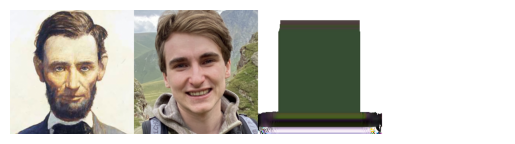

In [28]:
import matplotlib.pyplot as plt


res = tensor2image(torch.cat([out['source_information']['data_dict']['source_img'][0].cpu(),
                              out['source_information']['data_dict']['target_img'][0].cpu(),
                        out['render_masked'].cpu(), out['pred_target_shape_img'][0].cpu()], dim=2))
plt.imshow(res[..., ::-1])
plt.axis('off');plt.show()

In [29]:
new_out = infer.evaluate(source_image, Image.open('data/imgs/taras1.jpg'),
                        source_information_for_reuse=out['source_information'])

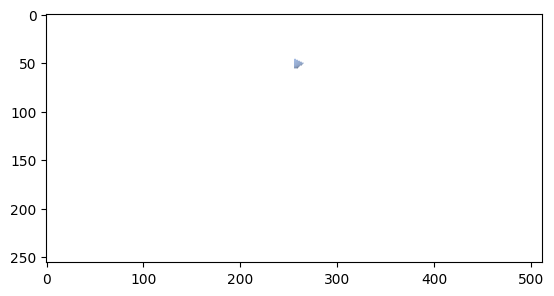

In [30]:
import matplotlib.pyplot as plt
key_to_show = 'pred_target_shape_img'


image_cat = np.concatenate([tensor2image(out[key_to_show][0]),
                tensor2image(new_out[key_to_show][0])], axis=1)
plt.imshow(image_cat[..., ::-1])
plt.show()

## Video inference

Download video with Jenya, thanks him a lot for this example:

```sh
wget https://www.dropbox.com/s/pht8dd901ff3vzy/jenya_driver.zip -O jenya_driver.zip
unzip jenya_driver.zip
mkdir data/video
mv jenya_driver data/video/
rm jenya_driver.zip
```

In [ ]:
from collections import defaultdict
from tqdm import tqdm
from PIL import Image

out = dict()
resulted_imgs = defaultdict(list)

video_folder = 'data/video/jenya_driver/'
image_frames = sorted(glob(f"{video_folder}/*", recursive=True), key=lambda x: int(x.split('/')[-1][:-4]))

source_image = Image.open('data/imgs/lincoln.jpg')

mask_hard_threshold = 0.5
N = len(image_frames)//20
for i in tqdm(range(0, N, 4)):
    new_out = infer.evaluate(source_image, Image.open(image_frames[i]),
                        source_information_for_reuse=out.get('source_information'))
    
    mask_pred = (new_out['pred_target_unet_mask'].cpu() > mask_hard_threshold).float()
    mask_pred = mask_errosion(mask_pred[0].float().numpy() * 255)
    render = new_out['pred_target_img'].cpu() * (mask_pred) + (1 - mask_pred)
        
    normals = process_black_shape(((new_out['pred_target_normal'][0].cpu() + 1) / 2 * mask_pred + (1 - mask_pred) ) )
    normals[normals==0.5]=1.
    
    resulted_imgs['res_normal'].append(tensor2image(normals))
    resulted_imgs['res_mesh_images'].append(tensor2image(new_out['pred_target_shape_img'][0]))
    resulted_imgs['res_renders'].append(tensor2image(render[0]))
    

In [ ]:
plt.imshow(resulted_imgs['res_normal'][0])
plt.axis('off')

## Show video results

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = np.array(resulted_imgs['res_renders'])

fig = plt.figure()
im = plt.imshow(video[0,:,:,::-1])
plt.axis('off')
plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,::-1])

def animate(i):
    im.set_data(video[i,:,:,::-1])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=video.shape[0], interval=30)
HTML(anim.to_html5_video())

### Inference over the folder of source

In [ ]:
## Infer over folder
result_root_dir = 'result_examples'
os.makedirs(result_root_dir,exist_ok=True )

sources_root = 'examples'
source_lists = glob(f'{sources_root}/*')
image_frames = sorted(glob(f"{video_folder}/*", recursive=True), key=lambda x: int(x.split('/')[-1][:-4]))

for src_img_path in source_lists[2:]:
    source_name = src_img_path.split('/')[-1][:-4]
    source_image = Image.open(src_img_path)
#     source_image.thumbnail((256,256), Image.ANTIALIAS)
#     data_dict = infer.process_source_for_input_dict(source_image, infer.source_transform)
    N = len(image_frames)
    resulted_imgs = defaultdict(list)
    new_out = dict()

    for i in tqdm(range(N)):
        new_out = infer.evaluate(source_image, Image.open(image_frames[i]),
                            source_information_for_reuse=new_out.get('source_information'), crop_center=True)

        mask_pred = (new_out['pred_target_unet_mask'].cpu() > mask_hard_threshold).float()
        mask_pred = mask_errosion(mask_pred[0].float().numpy() * 255)
        render = new_out['pred_target_img'].cpu() * (mask_pred) + (1 - mask_pred)

        normals = process_black_shape(((new_out['pred_target_normal'][0].cpu() + 1) / 2 * mask_pred + (1 - mask_pred) ) )
        normals[normals==0.5]=1.

        resulted_imgs['res_normal'].append(tensor2image(normals))
        resulted_imgs['res_renders'].append(tensor2image(render[0]))
    
    out = cv2.VideoWriter(f'{result_root_dir}/render_{source_name}.mp4',
                          cv2.VideoWriter_fourcc(*'mp4v'), 30, (256, 256))
    for i in resulted_imgs['res_renders']:
        out.write(i)
    out.release()
    
    out = cv2.VideoWriter(f'{result_root_dir}/normal_{source_name}.mp4', 
                          cv2.VideoWriter_fourcc(*'mp4v'), 30, (256, 256))
    for i in resulted_imgs['res_normal']:
        out.write(i)
    out.release()
    